In [1]:
from __future__ import annotations
import operator
from dotenv import load_dotenv
from typing import TypedDict, List, Annotated,Dict

from pydantic import BaseModel, Field

from langgraph.graph import StateGraph, START, END
from langgraph.types import Send
from langchain_groq import ChatGroq
from langchain_core.messages import SystemMessage, HumanMessage

load_dotenv()

True

In [2]:
llm=ChatGroq(
    model='llama-3.3-70b-versatile',
)

In [3]:
DESIGN_SYSTEM = """
Design System Rules:
- Dark theme first (bg-zinc-900, text-white)
- Cards: bg-zinc-800 rounded-2xl shadow-lg p-4
- Use gap-4 or gap-6 for spacing
- Use hover effects and transition
- Modern SaaS style
- Use lucide-react icons only
- No external images
"""

In [4]:
class Component(BaseModel):
    id: int
    name: str
    type: str = Field(..., description="One of: layout, ui, feature")
    description: str
    props: List[str] = Field(default_factory=list)
class Architecture(BaseModel):
    app_name: str
    components: List[Component]

class State(TypedDict):
    request: str
    plan: Architecture
    code_files: Annotated[List[str], operator.add]
    reviews: Annotated[List[str], operator.add]
    final_app: str


In [5]:
def orchestrator(state: State) -> dict:
    """Architect: Designs the component structure."""
    print(f" Designing architecture for: {state['request']}")
    
    plan = llm.with_structured_output(Architecture).invoke(
        [
            SystemMessage(content="""
You are a Senior Frontend Architect at a FAANG company.

Design a scalable, production-level React architecture.

Rules:
- Use Atomic Design principles (Layout, UI, Feature components)
- Separate presentational and container logic
- Think about reusability
- Define clear props
- Avoid putting all logic in one component
- Keep components clean and modular
Return structured output.
"""),
            HumanMessage(content=f"Request: {state['request']}"),
        ]
    )
    return {"plan": plan}

In [6]:
def fanout(state: State):
    """The Map Step: Dispatches work to parallel coders.""" 
    return [
        Send("worker", {
            "component": comp, 
            "app_name": state['plan'].app_name,
            "all_components": state['plan'].components
        }) 
        for comp in state['plan'].components
    ]

In [7]:
def worker(payload: dict) -> dict:
    """Worker: Writes the code for a SINGLE component.""" 
    comp = payload['component']
    app_name = payload['app_name']
    print(f"Coding Component: {comp.name}")
    tech_stack = """
- Use Tailwind CSS with modern UI patterns.
- Use flex, grid intelligently.
- Add hover states and transitions.
- Use rounded-2xl and shadow-lg for cards.
- Add subtle animations (transition, hover scale).
- Make UI visually appealing.
- Follow clean spacing (p-4, gap-4).
- Use lucide-react icons only.
- Do NOT use external images.
"""
    
    print(f"  Coding component: {comp.name}")

    code = llm.invoke(
        [
            SystemMessage(content="You are an expert React Developer. Write clean, functional code."),
             HumanMessage(content=f"""
App: {app_name}
Component Name: {comp.name}
Type: {comp.type}
Props: {comp.props}
Description: {comp.description}

{DESIGN_SYSTEM}

Return ONLY:
export default function {comp.name}(...) {{ ... }}
""")
    ]).content.strip()

    tagged = f"\n// ===== COMPONENT: {comp.name} =====\n{code}\n"
    return {"code_files": [tagged]}

In [8]:
def reviewer(state: State) -> dict:
    print(" Reviewing Components...")

    combined_code = "\n\n".join(state["code_files"])

    review = llm.invoke([
        SystemMessage(content="""
You are a Senior React Code Reviewer.

Check for:
- Missing keys in lists
- Bad prop patterns
- Tailwind misuse
- Accessibility issues
- Reusability issues
- Unnecessary state
- Performance issues

If code is good, say: APPROVED
Else suggest fixes.
"""),
        HumanMessage(content=combined_code)
    ]).content.strip()

    return {"reviews": [review]}

In [9]:
def reducer(state: State) -> dict:
    print("  Assembling final application (Generic)...")
    
    app_name = state['plan'].app_name
    all_components_code = "\n\n".join(state['code_files'])
     
    assembler_prompt = f"""
    You are an expert React Integrator.
    I have generated the following individual components for the app "{app_name}".
    
    ---
    COMPONENT DEFINITIONS:
    {all_components_code}
    ---
    
    YOUR TASK:
    Write the main 'export default function App() {{ ... }}' to combine these components.
    
    INSTRUCTIONS:
    1. **Analyze Props:** Look at the props defined in the components above (e.g., if 'Timer' takes 'timeLeft', you MUST create a 'timeLeft' state in App).
    2. **State Management:** Create the necessary top-level state (useState) and effects (useEffect) to make the app functional.
    3. **Event Handling:** If a component has callback props (e.g., 'onStart', 'onAdd'), implement the handler functions in App and pass them down.
    4. **Layout:** Arrange the components in a logical, clean layout using Tailwind CSS classes.
    5. **Output:** Return ONLY the 'App' component code.
    6. Avoid prop drilling if unnecessary.
7. Lift state only when required.
8. Optimize with memo if needed.
9. Avoid unnecessary useEffect.
10. Ensure clean imports.
    """

    app_logic = llm.invoke([
        SystemMessage(content="You are a Senior React Architect. Output only code."),
        HumanMessage(content=assembler_prompt)
    ]).content.strip()

    # Create the final file content
    final_source = f"""
    // APP: {app_name}
    import React, {{ useState, useEffect }} from 'react';
    import {{ LucideIcon }} from 'lucide-react';
 
    // SUB-COMPONENTS 
    {all_components_code}
 
    // MAIN APP CONTROLLER 
    {app_logic}
    """
    
    return {"final_app": final_source}

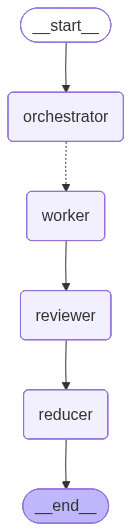

In [12]:
g = StateGraph(State)

g.add_node("orchestrator", orchestrator)
g.add_node("worker", worker)
g.add_node("reviewer", reviewer)
g.add_node("reducer", reducer)

g.add_edge(START, "orchestrator")
g.add_conditional_edges("orchestrator", fanout, ["worker"])
g.add_edge("worker", "reviewer")
g.add_edge("reviewer", "reducer")
g.add_edge("reducer", END)

app = g.compile()
app

In [13]:
out = app.invoke({"request": "Netflix like movie browsing interface"})

print("\n--- FINAL GENERATED APP ---\n")
print(out['final_app'])

 Designing architecture for: Netflix like movie browsing interface
Coding Component: MovieGrid
  Coding component: MovieGrid
Coding Component: MovieCard
  Coding component: MovieCard
Coding Component: MovieDetail
  Coding component: MovieDetail
Coding Component: Header
  Coding component: Header
Coding Component: SearchInput
  Coding component: SearchInput
Coding Component: MovieList
  Coding component: MovieList
 Reviewing Components...
  Assembling final application (Generic)...

--- FINAL GENERATED APP ---


    // APP: Netflix Movie Browser
    import React, { useState, useEffect } from 'react';
    import { LucideIcon } from 'lucide-react';

    // SUB-COMPONENTS 
    
// ===== COMPONENT: MovieGrid =====
```jsx
export default function MovieGrid({ movies, onClick }) {
  return (
    <div className="bg-zinc-900 p-4">
      <div className="grid grid-cols-1 sm:grid-cols-2 md:grid-cols-3 lg:grid-cols-4 gap-6">
        {movies.map((movie) => (
          <div
            key={movie.id}
 